In [37]:
# Variables
# file_path_edges = './scifi/scifi_triples.txt'
# file_path_entities = './scifi/entity2id.txt'

file_path_edges = '../Fast-TransX/data/FB15K/train2id.txt'
file_path_edges2 = '../Fast-TransX/data/FB15K/test2id.txt'
file_path_entities = '../Fast-TransX/data/FB15K/entity2id.txt'


embedding_size = 300
train_ratio = 0.7

batch_size = 100
epochs = 5

In [38]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping
import numpy as np

In [40]:
# Visualize Results
import matplotlib.pyplot as plt

In [44]:
edges_file = open(file_path_edges2, 'r')
entities_file = open(file_path_entities, 'r')

In [43]:
vocab_size = sum(1 for line in entities_file)
# Read edges
edges = {}
classes = set()
first = True
for line in edges_file:
    if first:
        first = False
        continue
    
    data = line.strip().split(" ")
    edge = (int(data[0]), int(data[1]))
    
    if len(data) < 3:
        data.append("")
    classes.add(data[2])
    if edge not in edges.keys():
        edges[edge] = [int(data[2])]
    else:
        edges[edge].append(int(data[2]))

In [45]:
for line in edges_file:
    if first:
        first = False
        continue
    
    data = line.strip().split(" ")
    edge = (int(data[0]), int(data[1]))
    
    if len(data) < 3:
        data.append("")
    classes.add(data[2])
    if edge not in edges.keys():
        edges[edge] = [int(data[2])]
    else:
        edges[edge].append(int(data[2]))

IndexError: list index out of range

In [5]:
len(edges)

70617

In [6]:
# Preprocessing functions
def multi_hot(types):
    vec = np.zeros(len(classes))
    x = True
    for t in types:
        x = False
        vec[t] = 1
    if x:
        print(":(")
    return vec

def preprocess(pair, types):
    x = np.array([pair[0]] + [pair[1]])
    y = multi_hot(types)
    return x, y

In [7]:
# Preprocess data
data = []
for key in edges.keys():
    x, y = preprocess(key, edges[key])
    data.append(np.append(x, y))
x_len = len(x)
data = np.array(data).astype(np.float)

In [8]:
# Split data in to training and test set
np.random.shuffle(data)
x = data[:, :x_len]
y = data[:, x_len:]

training_size = int(len(data) * train_ratio)

x_train = x[:training_size]
y_train = y[:training_size]
x_test = x[training_size:]
y_test = y[training_size:]

In [9]:
(len(x_train), len(x_test))

(49431, 21186)

In [10]:
classes_size = len(classes)
classes_size

116

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=2))
model.add(GlobalAveragePooling1D())
model.add(Dense(classes_size))

In [13]:
epochs

5

In [23]:
training_distribution = np.sum(y_train.astype(np.float), axis=0)

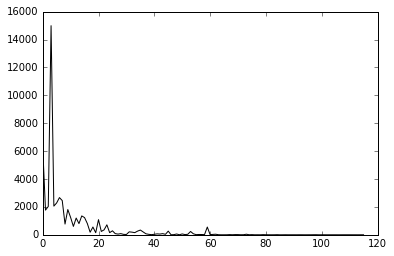

In [24]:
plt.plot(training_distribution, color='black')

In [12]:
early_stopping = EarlyStopping(monitor='categorical_accuracy', min_delta=0, patience=2, verbose=0, mode='auto', baseline=None)

In [33]:
# Training the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

model.fit(x_train, y_train,
          epochs=epochs,
          batch_size=batch_size)

Epoch 1/5
 7100/49431 [===>..........................] - ETA: 27s - loss: 10.8238 - categorical_accuracy: 0.4454

KeyboardInterrupt: 

In [32]:
score = model.evaluate(x_test, y_test, batch_size=batch_size)
score

21186/21186 [==============================] - 0s 12us/step


[10.322020056789459, 0.4465684859827829]

In [26]:
y_predicted = np.around(model.predict(x_test))

In [27]:
expected = np.sum(y_test.astype(np.float), axis=0)
actual = np.sum(y_predicted, axis=0)
actual[actual < 0] = 0

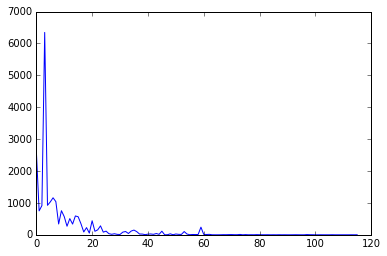

In [28]:
plt.plot(expected)

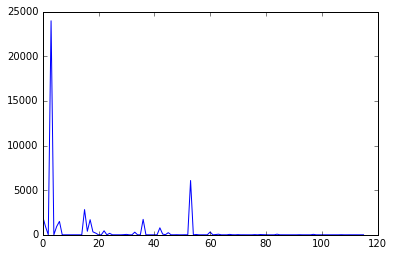

In [29]:
plt.plot(actual)

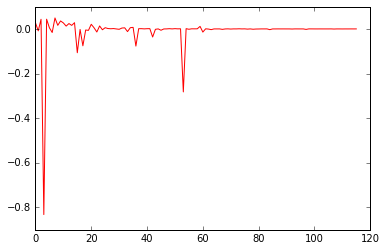

In [30]:
plt.plot((expected - actual)/y_test.shape[0], color='r')

In [ ]:
# Baseline Model
def model(features, labels, mode, params, config):
    bow_input = tf.reduce_mean(tf.one_hot(features, vocab_size), 1) # tf.placeholder(tf.float32, shape=(None, vocab_size), name="x")
    label = labels # tf.placeholder(tf.float32, shape=(None, classes_size), name="y")
    embedding = tf.Variable(tf.random_normal([embedding_size, vocab_size], stddev=0.1), name="embedding")
    parameters = tf.Variable(tf.random_normal([classes_size, embedding_size], stddev=0.1), name="weights")
    
    prediction = tf.nn.softmax(
                            tf.matmul(parameters,
                                        tf.matmul(embedding, bow_input)))
    
    loss = -1 * tf.reduce_sum(
        tf.matmul(label,
                    tf.log(prediction)))
    
    optimizer = AdamOptimizer()
    
    return tf.estimator.EstimatorSpec(mode, predictions=prediction, loss=loss, train_op=optimizer.minimize(loss))